In [242]:
import sqlite3
import re
import string
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'ytick.alignment' : 'center'
})

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV, ElasticNetCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

In [2]:
conn = sqlite3.connect('database.sqlite')

In [3]:
query = """
SELECT r.reviewid,
       r.title,
       r.artist,
       r.score,
       r.best_new_music,
       r.author,
       r.pub_date,
       c.content,
       g.genre
FROM reviews r
JOIN genres g ON g.reviewid = r.reviewid
JOIN content c ON c.reviewid = r.reviewid
WHERE g.genre IN ('rock', 'rap', 'experimental', 'pop/r&b', 'electronic')
ORDER BY pub_date;
"""

df = pd.read_sql(query, conn)
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print(test_dups[test_dups != 1].shape)

rock            9442
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
Name: genre, dtype: int64
(3062,)


In [4]:
genre_order = ['pop/r&b', 'rap', 'experimental', 'electronic', 'rock']
genre_type = pd.api.types.CategoricalDtype(genre_order, ordered=True)
df['genre'] = pd.Series(df['genre'], dtype=genre_type)

df = df.sort_values('genre').groupby('reviewid').first()
df = pd.DataFrame(df.to_records())
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print(test_dups[test_dups != 1].shape)

(0,)


In [5]:
class MemorizingSnowballStemmer():
    
    def __init__(self, lang, **kwargs):
        self._stemmer = SnowballStemmer(lang, **kwargs)
        self._mem = {}
        
    def stem(self, word):
        stemmed_word = self._stemmer.stem(word)
        if stemmed_word in self._mem:
            if word not in self._mem[stemmed_word]:
                self._mem[stemmed_word][word] = 1
            else:
                self._mem[stemmed_word][word] += 1
        else:
            self._mem[stemmed_word] = {word: 1}
        return stemmed_word
    
    def unstem(self, stem):
        if stem in self._mem:
            return self._mem[stem]
        else:
            return {}
        
    def unstem_most_common(self, stem):
        if stem in self._mem:
            freq_dict = self._mem[stem]
            return sorted(freq_dict, key=freq_dict.get, reverse=True)[0]

In [6]:
stemmer = MemorizingSnowballStemmer('english', ignore_stopwords=True)
strip_punct = str.maketrans('', '', string.punctuation)
stem_text = lambda s: ' '.join([stemmer.stem(word) for word in word_tokenize(s.translate(strip_punct))])
        
df['content_stemmed'] = df['content'].apply(stem_text)

In [7]:
vect_tfidf = TfidfVectorizer(stop_words='english', min_df=5)
words_tfidf = vect_tfidf.fit_transform(df['content_stemmed'])
print(words_tfidf.shape)

(14874, 30862)


In [8]:
vect_count = CountVectorizer(stop_words='english', min_df=5)
words_count = vect_count.fit_transform(df['content_stemmed'])
print(words_count.shape)

(14874, 30862)


In [9]:
target_columns = ['score', 'best_new_music', 'genre']
targets = df[target_columns]
words_tfidf_train, words_tfidf_test, words_count_train, words_count_test, targets_train, targets_test \
    = train_test_split(words_tfidf, words_count, targets, random_state=420)

In [10]:
pca = PCA(n_components=10)
pca_features = pca.fit_transform(words_tfidf_train.toarray())

clf_svm = LinearSVC()
clf_svm.fit(pca_features, targets_train['genre'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

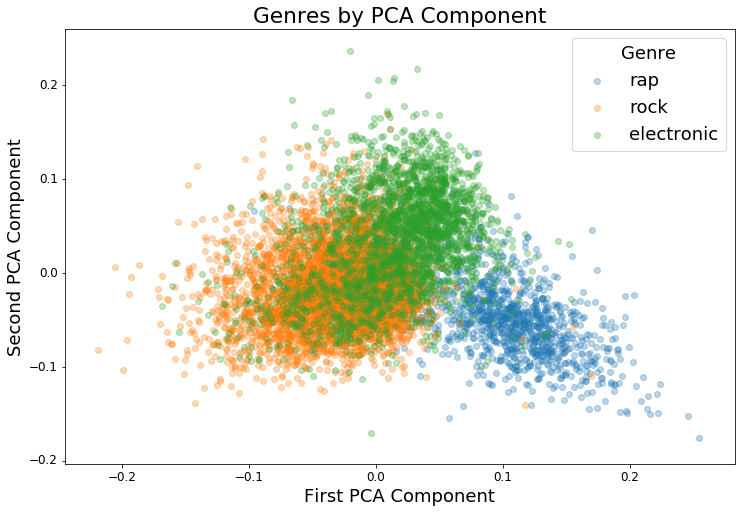

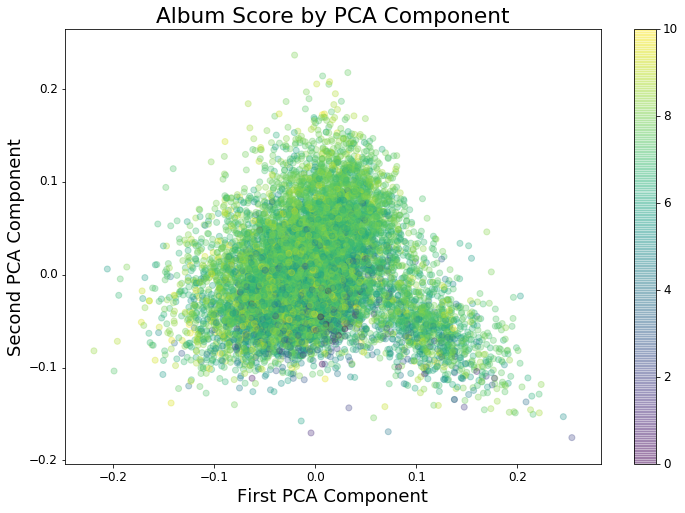

In [262]:
fig =plt.figure(figsize=(12,8))
ax = fig.gca()

for genre in ['rap', 'rock', 'electronic']:
    genre_selector = targets_train['genre'] == genre
    ax.scatter(pca_features[:, 0][genre_selector],
                pca_features[:, 1][genre_selector], alpha=0.3, label=genre)
    
ax.legend(title="Genre")
ax.set_title("Genres by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.savefig('genres_by_pca.pdf')

fig =plt.figure(figsize=(12,8))
ax = fig.gca()
sc = ax.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.3, c=targets_train['score'], cmap='viridis')
ax.set_title("Album Score by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.colorbar(sc)
plt.savefig('score_by_pca.pdf')

Training Accuracy: 0.6829224562976244
Test Accuracy: 0.6727614950255445

Training f1: [0.78866147 0.63801453 0.25889213 0.84556506 0.03797468]
Test f1: [0.77982541 0.61955241 0.24497258 0.84180791 0.0166205 ]


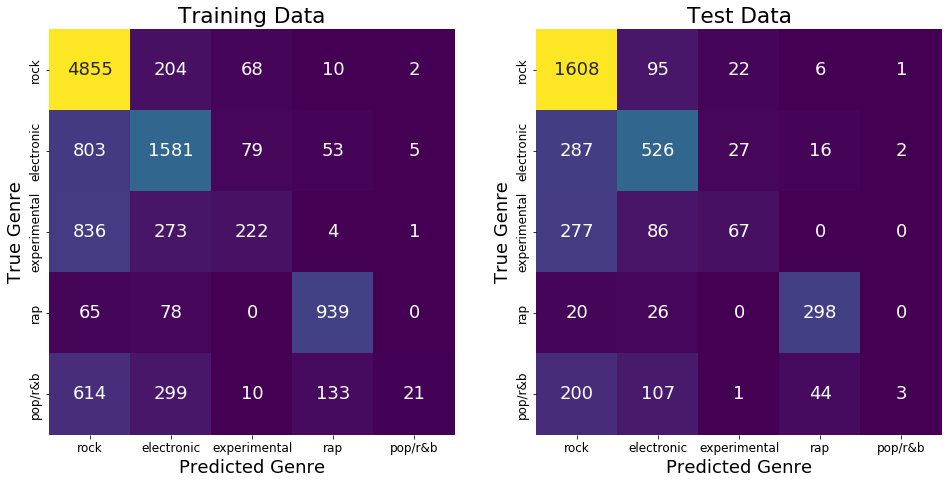

In [263]:
genre_labels = list(reversed(genre_order))
pred_train = clf_svm.predict(pca.transform(words_tfidf_train.toarray()))
pred_test = clf_svm.predict(pca.transform(words_tfidf_test.toarray()))
print('Training Accuracy: {}'.format(accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(f1_score(targets_train['genre'], pred_train, average=None, labels=genre_labels)))
print('Test f1: {}'.format(f1_score(targets_test['genre'], pred_test, average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'], pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'], pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax = axs[0], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax = axs[1], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_svm.pdf')

In [13]:
clf_nb = BernoulliNB()
clf_nb.fit(words_count_train, targets_train['genre'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training Accuracy: 0.8218735992828328
Test Accuracy: 0.7023393385318634

Training f1: [0.87117614 0.78503937 0.75892207 0.89145497 0.6491913 ]
Test f1: [0.8003337  0.6536531  0.53125    0.82285714 0.30174081]


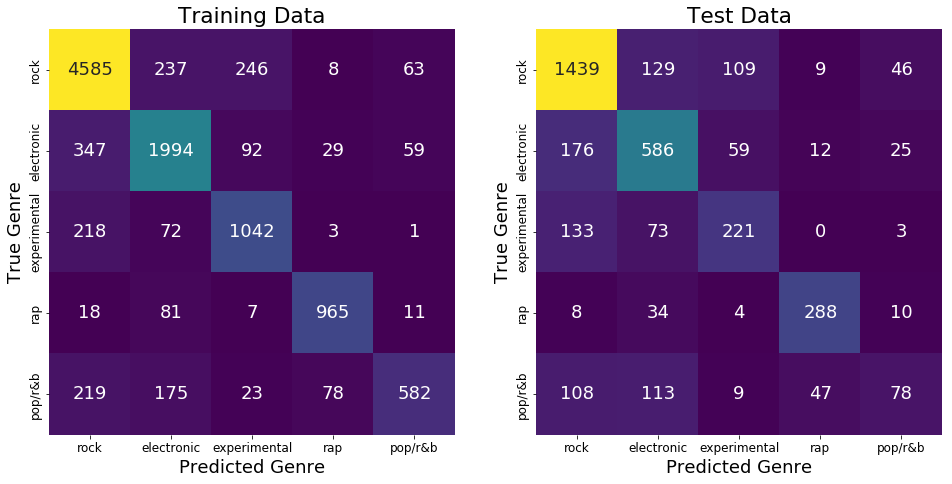

In [264]:
genre_labels = list(reversed(genre_order))
pred_train = clf_nb.predict(words_count_train.toarray())
pred_test = clf_nb.predict(words_count_test.toarray())
print('Training Accuracy: {}'.format(accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(f1_score(targets_train['genre'], pred_train, average=None, labels=genre_labels)))
print('Test f1: {}'.format(f1_score(targets_test['genre'], pred_test, average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'], pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'], pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax = axs[0], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax = axs[1], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_nb.pdf')

In [40]:
reg = LassoLarsCV(cv=5, n_jobs=8)
reg.fit(words_tfidf_train.astype(np.float32).toarray(), targets_train['score'])

pred_train = reg.predict(words_tfidf_train)
pred_test = reg.predict(words_tfidf_test)
print("Train Score: {}".format(r2_score(targets_train['score'], pred_train)))
print("Test Score: {}".format(r2_score(targets_test['score'], pred_test)))

coef = reg.coef_
terms = vect_tfidf.inverse_transform(coef)

term_df = pd.DataFrame({
    'term': terms[0],
    'coef': coef[np.abs(coef)>0]
}).sort_values('coef')

term_df['unstemmed'] = term_df['term'].apply(stemmer.unstem_most_common)

Train Score: 0.3607860867733067
Test Score: 0.2823405536169904


In [265]:
print("Number of regressors: {}".format(term_df.shape[0]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(term_df)
term_df.to_csv("terms_from_lasso.csv")

Number of regressors: 352
                term       coef         unstemmed
160          insipid -10.996981           insipid
327         unlisten -10.443879      unlistenable
35             bland  -9.786086             bland
323         unfortun  -9.674447     Unfortunately
347             wors  -9.534159             worse
316        travistan  -8.122936         Travistan
187               m2  -7.254521                M2
72            decent  -6.930387            decent
252          problem  -6.920166           problem
86             dreck  -6.819590             dreck
121             frat  -6.549007              frat
319           turgid  -6.403541            turgid
64             cosmo  -6.319101             Cosmo
91            duritz  -6.187328            Duritz
22         audioslav  -6.095916        Audioslave
197          mediocr  -6.083906          mediocre
126          generic  -6.071394           generic
232          passabl  -5.718697          passable
346          woodwat  -5

In [36]:
def find_term(df, t):
    select = df['content_stemmed'].str.contains(t)
    return df[select]

test_df = find_term(df, 'insipid')

print(test_df)

       reviewid                                              title  \
61          113                           all girl summer fun band   
71          134                                        white noise   
145         292                                   as if to nothing   
387         717                                  born free forever   
1145       2420                                    spend the night   
1341       2733                                               fire   
1354       2749                                    no games no fun   
1530       3099                      welcoming home the astronauts   
1705       3430                      something to write home about   
1791       3616                                            essence   
1797       3624                                invent modest fires   
2177       4338                                           get born   
2273       4555                                          kaospilot   
2437       4836     

In [200]:
select_artist = df.groupby('artist').count()['reviewid'] >= 3

scores_df = pd.DataFrame({
    'first_album': df.sort_values('pub_date').groupby('artist').first()[select_artist]['score'],
    'second_album': df.sort_values('pub_date').groupby('artist').nth(1)[select_artist]['score'],
    'third_album': df.sort_values('pub_date').groupby('artist').nth(2)[select_artist]['score'],
    #'fourth_album': df.sort_values('pub_date').groupby('artist').nth(3)[select_artist]['score']
})

/home/tinsmancb/.virtualenvs/blog_post-Auhn-f79/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/tinsmancb/.virtualenvs/blog_post-Auhn-f79/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


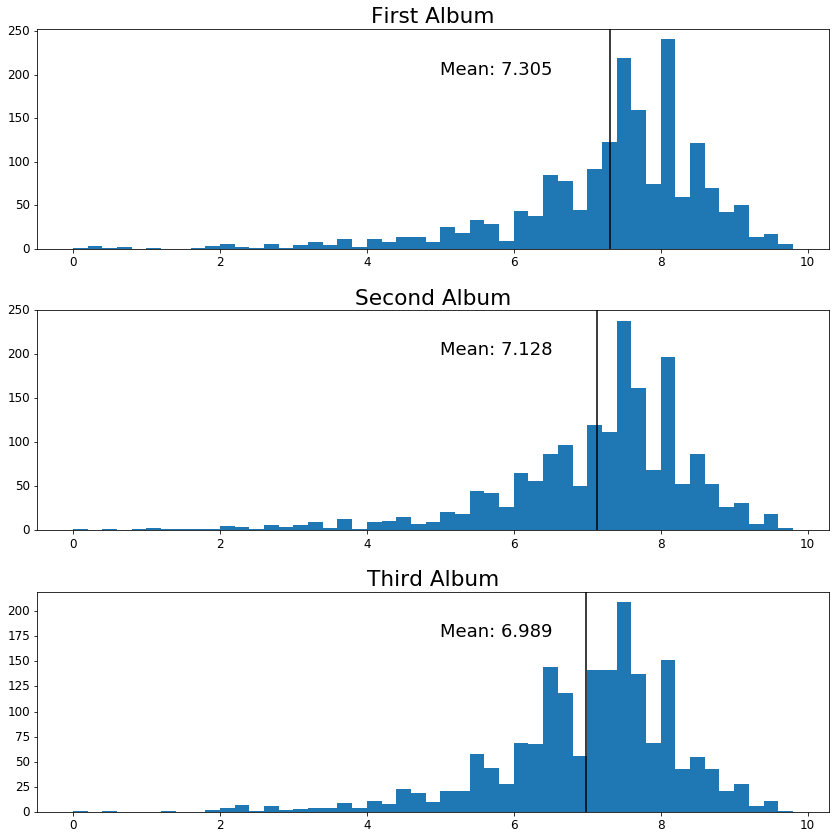

In [267]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

bins = np.arange(0, 10, 0.2)
axs[0].hist(scores_df['first_album'], bins=bins);
first_mean = scores_df['first_album'].mean()
axs[0].axvline(first_mean, c='k')
axs[0].set_title('First Album')
axs[0].annotate('Mean: {:.3f}'.format(first_mean), (5.0, 200))

axs[1].hist(scores_df['second_album'], bins=bins);
second_mean = scores_df['second_album'].mean()
axs[1].axvline(scores_df['second_album'].mean(), c='k')
axs[1].set_title('Second Album')
axs[1].annotate('Mean: {:.3f}'.format(second_mean), (5.0, 200))

axs[2].hist(scores_df['third_album'], bins=bins);
third_mean = scores_df['third_album'].mean()
axs[2].axvline(scores_df['third_album'].mean(), c='k')
axs[2].set_title('Third Album')
axs[2].annotate('Mean: {:.3f}'.format(third_mean), (5.0, 175))

plt.tight_layout()
plt.savefig('score_dist.pdf')

In [255]:
print(scores_df['first_album'].mean())
print(scores_df['second_album'].mean())
print(scores_df['third_album'].mean())

print(scipy.stats.ttest_ind(scores_df['first_album'], scores_df['second_album']))
print(scipy.stats.ttest_ind(scores_df['second_album'], scores_df['third_album']))

7.305423353624794
7.128278915329275
6.989097952407304
Ttest_indResult(statistic=3.907604929073968, pvalue=9.49234930457459e-05)
Ttest_indResult(statistic=3.1958868854167326, pvalue=0.001406031124730276)
